In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator # for minor ticks
from scipy.optimize import curve_fit
import requests
import warnings

warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")
warnings.filterwarnings("ignore", message="overflow encountered in power")
warnings.filterwarnings("ignore", message="overflow encountered in multiply", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in subtract")


In [2]:
lumi = 36000.
fraction = 0.1

In [3]:
# Dictionary of samples to be processed
samples = {
    
    'data': {'list' : [
        'data15_periodJ',
        'data16_periodB',
        'data16_periodK',
        'data16_periodC',
        'data15_periodE',
        'data16_periodF',
        'data16_periodG',
        'data16_periodD',
        'data15_periodD',
        'data15_periodH',
        'data15_periodF',
        'data15_periodG',
        'data16_periodE',
        'data16_periodA',
        'data16_periodI',
        'data16_periodL',
        ],},
    
    
    
    # Main Monte Carlo (MC) sample: top quark pair production
    'wz' : {  'list' : ['mc_700601.Sh_2212_lllv'],},

    # Diboson WW and ZZ
    'diboson' : {  'list' : [
        'mc_700493.Sh_2211_ZqqZll',
        'mc_700488.Sh_2211_WlvWqq',
        'mc_700492.Sh_2211_WqqZll',
        'mc_700600.Sh_2212_llll'
        ],},

    # Z + jets and W + jets
    'vjets' : {  'list' : [
        'mc_700323.Sh_2211_Zmumu_maxHTpTV2_BFilter',
        'mc_700324.Sh_2211_Zmumu_maxHTpTV2_CFilterBVeto',
        'mc_700325.Sh_2211_Zmumu_maxHTpTV2_CVetoBVeto',
        'mc_700470.Sh_2211_Zmumu_maxHTpTV2_m10_40_pT5_BFilter',
        'mc_700471.Sh_2211_Zmumu_maxHTpTV2_m10_40_pT5_CFilterBVeto',
        'mc_700472.Sh_2211_Zmumu_maxHTpTV2_m10_40_pT5_CVetoBVeto',
        'mc_700320.Sh_2211_Zee_maxHTpTV2_BFilter',
        'mc_700321.Sh_2211_Zee_maxHTpTV2_CFilterBVeto',
        'mc_700322.Sh_2211_Zee_maxHTpTV2_CVetoBVeto',
        'mc_700467.Sh_2211_Zee_maxHTpTV2_m10_40_pT5_BFilter',
        'mc_700468.Sh_2211_Zee_maxHTpTV2_m10_40_pT5_CFilterBVeto',
        'mc_700469.Sh_2211_Zee_maxHTpTV2_m10_40_pT5_CVetoBVeto',
        'mc_700792.Sh_2214_Ztautau_maxHTpTV2_BFilter',
        'mc_700793.Sh_2214_Ztautau_maxHTpTV2_CFilterBVeto',
        'mc_700794.Sh_2214_Ztautau_maxHTpTV2_CVetoBVeto',
        
        'mc_700341.Sh_2211_Wmunu_maxHTpTV2_BFilter',
        #'mc_700342.Sh_2211_Wmunu_maxHTpTV2_CFilterBVeto',
        #'mc_700343.Sh_2211_Wmunu_maxHTpTV2_CVetoBVeto',
        'mc_700344.Sh_2211_Wtaunu_L_maxHTpTV2_BFilter',
        #'mc_700345.Sh_2211_Wtaunu_L_maxHTpTV2_CFilterBVeto',
        #'mc_700346.Sh_2211_Wtaunu_L_maxHTpTV2_CVetoBVeto',
        'mc_700347.Sh_2211_Wtaunu_H_maxHTpTV2_BFilter',
        #'mc_700348.Sh_2211_Wtaunu_H_maxHTpTV2_CFilterBVeto',
        #'mc_700349.Sh_2211_Wtaunu_H_maxHTpTV2_CVetoBVeto',
        'mc_700338.Sh_2211_Wenu_maxHTpTV2_BFilter',
        #'mc_700339.Sh_2211_Wenu_maxHTpTV2_CFilterBVeto',
        #'mc_700340.Sh_2211_Wenu_maxHTpTV2_CVetoBVeto',
        
        ],},

    # Single top quark production and ttbar samples
    'other' : {  'list' : [               
        'mc_410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad',
        'mc_410471.PhPy8EG_A14_ttbar_hdamp258p75_allhad',
        'mc_410644.PowhegPythia8EvtGen_A14_singletop_schan_lept_top',
        'mc_410645.PowhegPythia8EvtGen_A14_singletop_schan_lept_antitop',
        'mc_601497.PhPy8EG_A14_ttbar_pThard1_singlelep',
        'mc_410658.PhPy8EG_A14_tchan_BW50_lept_top',
        'mc_410659.PhPy8EG_A14_tchan_BW50_lept_antitop',
        'mc_601487.PhPy8EG_A14_tchan_pThard1_lep_antitop',
        'mc_601489.PhPy8EG_A14_tchan_pThard1_lep_top',
        'mc_601491.PhPy8EG_A14_ttbar_pThard1_dil',
        'mc_601495.PhPy8EG_A14_ttbar_pThard1_allhad',
        ],},

        }

In [4]:
def calc_weight(data):

    scale_factors = (data["ScaleFactor_PILEUP"] * data["ScaleFactor_ELE"] * data["ScaleFactor_MUON"] * data["ScaleFactor_LepTRIGGER"])
    
    norm_factor = (data["xsec"] * data["kfac"] * data["filteff"]) / data["sum_of_weights"]
    
    weight = data["mcWeight"] * scale_factors * norm_factor * lumi

    return weight

In [5]:
def cut_trig(trigE,trigM):
    return trigE | trigM

In [6]:
def three_lep(lep_n):
    return lep_n == 3


In [7]:
def cut_met_et(met_et):
    return met_et > 30

In [8]:
def cut_lep_pt(lep_pt):
    pt = lep_pt 
    cut1 = ak.sum(pt > 20, axis=1) >= 3
    cut2 = ak.sum(pt > 25, axis=1) >= 1
    return cut1 & cut2

In [9]:
def cut_track_iso(pt_cone, pt):
    cut = ak.sum(np.abs(pt_cone/pt) < 0.15, axis=1) > 2
    return cut

In [10]:

def cut_cal_iso(et_cone, pt):
    cut = ak.sum(np.abs(et_cone/pt) < 0.15, axis=1) > 2
    return cut

In [11]:
def ID_iso_cut(ID,iso):
    return ak.sum(ID & iso,axis=1) > 2

In [12]:
def sfos_pair(flavor, charge):

    # Generate all unique pairs of particles for each event
    # Combinations of 2 ensure no particle is compared with itself
    f_pairs = ak.combinations(flavor, 2, fields=["flavor_0", "flavor_1"])
    c_pairs = ak.combinations(charge, 2, fields=["charge_0", "charge_1"])

    # Same-flavor check: both particles in the pair must be of the same type
    same_flavor = f_pairs.flavor_0 == f_pairs.flavor_1

    # Opposite-sign check: the charges of the particles must be different
    opposite_sign = c_pairs.charge_0 != c_pairs.charge_1

    # Find where both conditions are met
    sfos = same_flavor & opposite_sign

    # We want at least one SFOS pair per event
    sfos_cut = ak.any(sfos, axis=1)

    return sfos_cut

In [13]:
def sfos_mass(flavor, charge, E, pt, eta, phi):
    # Convert units to GeV
    lep_E = E 
    lep_pt = pt 

    # Calculate lepton px, py, pz components
    lep_px = lep_pt * np.cos(phi)
    lep_py = lep_pt * np.sin(phi)
    lep_pz = lep_pt / np.tan(2.0 * np.arctan(np.exp(-eta)))

    # Generate all possible lepton pairs
    lep_pairs_E = ak.combinations(lep_E, 2, fields=['E0', 'E1'])
    lep_pairs_px = ak.combinations(lep_px, 2, fields=['px0', 'px1'])
    lep_pairs_py = ak.combinations(lep_py, 2, fields=['py0', 'py1'])
    lep_pairs_pz = ak.combinations(lep_pz, 2, fields=['pz0', 'pz1'])

    # Generate flavor and charge pairs
    flavor_pairs = ak.combinations(flavor, 2, fields=["flavor_0", "flavor_1"])
    charge_pairs = ak.combinations(charge, 2, fields=["charge_0", "charge_1"])

    # Apply SFOS condition
    same_flavor = flavor_pairs.flavor_0 == flavor_pairs.flavor_1
    opposite_sign = charge_pairs.charge_0 != charge_pairs.charge_1
    sfos_mask = same_flavor & opposite_sign
    
    pairs = ak.combinations(ak.zip({"flavor": flavor, "charge": charge, "E": E, "pt": pt, "eta": eta, "phi": phi}), 2)
    
    # Apply mask to keep only SFOS pairs
    lep_pairs_E = lep_pairs_E[sfos_mask]
    lep_pairs_px = lep_pairs_px[sfos_mask]
    lep_pairs_py = lep_pairs_py[sfos_mask]
    lep_pairs_pz = lep_pairs_pz[sfos_mask]

    # Calculate the invariant mass only for SFOS pairs
    pair_mass = np.sqrt((lep_pairs_E.E0 + lep_pairs_E.E1) ** 2 -
                        ((lep_pairs_px.px0 + lep_pairs_px.px1) ** 2 +
                         (lep_pairs_py.py0 + lep_pairs_py.py1) ** 2 +
                         (lep_pairs_pz.pz0 + lep_pairs_pz.pz1) ** 2))

    return pair_mass

In [14]:
def sfos_analysis(flavor, charge, pair_mass):
    z_mass = 91

    # Step 1: Apply the Z boson mass window cut (81–101 GeV)
    mass_cut = (pair_mass > 81) & (pair_mass < 101)
    z_mass_cut = ak.any(mass_cut, axis=1)  # Check if any pair passes the mass cut

    # Step 2: Filter out events that don't pass the Z mass window cut
    pair_mass = pair_mass[z_mass_cut]

    # Step 3: Find the SFOS pair with mass closest to the Z boson mass (91 GeV)
    closest_pair_index = ak.argmin(np.abs(pair_mass - z_mass), axis=1)

    # Extract the closest pair mass
    closest_pair_mass = pair_mass[ak.local_index(pair_mass, axis=1) == closest_pair_index]
    closest_pair_mass = ak.flatten(closest_pair_mass)


    # Retrieve the indices of leptons in the closest SFOS pair
    all_index_pairs = ak.combinations(ak.local_index(flavor), 2)
    all_index_pairs = all_index_pairs[z_mass_cut]  # Filter indices for events passing Z mass cut
    closest_pair_indices = all_index_pairs[ak.local_index(all_index_pairs, axis=1) == closest_pair_index]

    # Extract indices for the paired leptons
    index1, index2 = ak.unzip(closest_pair_indices[:, 0])
    
    filtered_flavor = flavor[z_mass_cut]
    
    # Use ak.local_index to properly align filtered_flavor with indices
    index1_flavor = filtered_flavor[ak.local_index(filtered_flavor, axis=1) == index1]
    index2_flavor = filtered_flavor[ak.local_index(filtered_flavor, axis=1) == index2]

    # Identify ee and mumu pairs
    is_ee = (index1_flavor == 11) & (index2_flavor == 11)
    is_mumu = (index1_flavor == 13) & (index2_flavor == 13)

    # Extract masses for ee and μμ pairs
    #closest_ee_mass = ak.mask(closest_pair_mass, is_ee)
    #closest_mumu_mass = ak.mask(closest_pair_mass, is_mumu)
    
    closest_ee_mass = ak.flatten(ak.mask(closest_pair_mass, is_ee))
    closest_mumu_mass = ak.flatten(ak.mask(closest_pair_mass, is_mumu))


    return z_mass_cut, index1, index2, closest_pair_mass, closest_ee_mass, closest_mumu_mass 

In [15]:
def unpaired_lepton(pt, phi, tipe, index1, index2):

    # Determine the unpaired lepton index based on indices in closest_pair_indices
    unpaired_index = ak.where((index1 == 0) & (index2 == 1), 2,
                    ak.where((index1 == 0) & (index2 == 2), 1,
                    ak.where((index1 == 1) & (index2 == 2), 0, -1)))  # -1 is a fallback

    # Retrieve properties of the unpaired lepton for each event
    unpaired_lepton_pt = pt[ak.local_index(pt, axis=1) == unpaired_index]
    unpaired_lepton_phi = phi[ak.local_index(phi, axis=1) == unpaired_index]
    unpaired_lepton_type = tipe[ak.local_index(tipe, axis=1) == unpaired_index]

    return unpaired_lepton_pt, unpaired_lepton_phi, unpaired_lepton_type


In [16]:
def w_boson_mass(unpaired_lepton_pt, unpaired_lepton_phi, met_et, met_phi):

    # Convert from MeV to GeV
    lep_pt = ak.flatten(unpaired_lepton_pt)  # Transverse momentum of the unpaired lepton (GeV)
    lep_phi = ak.flatten(unpaired_lepton_phi)  # Azimuthal angle of the unpaired lepton (rad)
    met_et = met_et  # MET (GeV)
    # Calculate the transverse components (px and py) of the lepton and MET
    lep_px = lep_pt * np.cos(lep_phi)
    lep_py = lep_pt * np.sin(lep_phi)
    met_px = met_et * np.cos(met_phi)
    met_py = met_et * np.sin(met_phi)

    # Calculate the transverse mass of the W boson
    w_mt_squared = ((lep_pt + met_et)**2 - ((lep_px + met_px)**2 + (lep_py + met_py)**2))
    w_mt_squared = np.maximum(w_mt_squared, 0)  # Set negative values to zero


    #w_mt_squared = np.maximum(w_mt_squared, 0)  # Ensure no negative values
    w_mt = np.sqrt(w_mt_squared)
    w_mass_cut = w_mt > 30
    
    # Check if the W boson transverse mass is greater than 30 GeV
    return w_mass_cut, w_mt

In [17]:
def split_by_type(w_mt, unpaired_lepton_type):
    unpaired_lepton_type = ak.flatten(unpaired_lepton_type)
    # Create masks for muons and electrons
    is_muon = unpaired_lepton_type == 13
    is_electron = unpaired_lepton_type == 11

    # Use the mask to filter w_mt for muons and electrons
    w_mt_muon = ak.mask(w_mt, is_muon)
    w_mt_electron = ak.mask(w_mt, is_electron)

    return w_mt_muon, w_mt_electron

In [18]:
def read_file(path,sample,loop):
    data_all = [] # define empty list to hold all data for this sample

    # open the tree called mini using a context manager (will automatically close files/resources)
    with uproot.open(path + f":analysis;1") as tree:
        numevents = tree.num_entries
        for data in tree.iterate(
            [
                "mcWeight", "sum_of_weights", "ScaleFactor_ELE", "ScaleFactor_MUON", "ScaleFactor_LepTRIGGER", 
                "ScaleFactor_PILEUP", "xsec", "filteff", "kfac", "trigE", "trigM", "lep_n", "lep_pt",
                "lep_eta", "lep_phi", "lep_charge", "lep_type", "met", "met_phi", 
                "lep_e", "lep_isTightID", "lep_isLooseIso", "lep_topoetcone20", "lep_ptvarcone30",
            ],
            library="ak",
            entry_start=int(round(numevents * fraction * loop, 0)),
            entry_stop=int(round(numevents * fraction * (loop + 1), 0))
        ):
            nIn = len(data) # number of events in this batch
        
            # Apply cuts step by step, updating counters as we go
            data = data[cut_trig(data.trigE, data.trigM)]
            
            data = data[three_lep(data.lep_n)]
            
            data = data[cut_met_et(data.met)]
        
            data = data[cut_lep_pt(data.lep_pt)]
        
            data = data[ID_iso_cut(data.lep_isTightID, data.lep_isLooseIso)]
        
            data = data[cut_cal_iso(data.lep_topoetcone20, data.lep_pt)]
    
            data = data[cut_track_iso(data.lep_ptvarcone30, data.lep_pt)]
        

            # Apply SFOS pair cut
            data = data[sfos_pair(data.lep_type, data.lep_charge)]
            

            # Apply Z boson mass cut on SFOS pairs
            pair_mass = sfos_mass(data.lep_type, data.lep_charge, data.lep_e, data.lep_pt, data.lep_eta, data.lep_phi)
            
            z_mass_cut, index1, index2, closest_pair_mass, closest_ee_mass, closest_mumu_mass  = sfos_analysis(data.lep_type, data.lep_charge, pair_mass)
            data = data[z_mass_cut]
            

            unpaired_lepton_pt, unpaired_lepton_phi, unpaired_lepton_type = unpaired_lepton(data.lep_pt, data.lep_phi, data.lep_type, index1, index2)
            w_mass_cut, w_mt = w_boson_mass(unpaired_lepton_pt, unpaired_lepton_phi, data.met, data.met_phi)
            data = data[w_mass_cut]
            
            w_mt_muon, w_mt_electron = split_by_type(w_mt[w_mass_cut], unpaired_lepton_type[w_mass_cut])
            
             

            data['wtmass'] = w_mt[w_mass_cut]
            data['wmuon'] = w_mt_muon
            data['welectron'] = w_mt_electron
            data['zmass'] = closest_pair_mass[w_mass_cut]
            data['ee_pair_mass'] = closest_ee_mass[w_mass_cut]
            data['mumu_pair_mass'] = closest_mumu_mass[w_mass_cut]
            # Compute weights
            if 'data' not in sample:
                data['weight'] = calc_weight(data)
            else:
                data['weight'] = ak.zeros_like(data['met'])

            data_all.append(data)
            del data, pair_mass, z_mass_cut, w_mass_cut  # Free up memory

    return ak.concatenate(data_all)

In [19]:
def get_data_from_files(type_data, loop):
    
    data = [] # define empty list to hold data
    for val in samples[type_data]['list']: # loop over each file        
        if type_data == "data":
            prefix = "Data/"
        else: prefix = "MC/"
        tuple_path = "root://eosuser.cern.ch//eos/user/e/egramsta/OpenData/FEB2025/exactly3lep/" 
        fileString = tuple_path+prefix+val+".exactly3lep.root" 
        data.append(read_file(fileString,val,loop)) 

    return ak.concatenate(data)

In [20]:
def analysis(data_type,loop):

    # Process data for data_type sample
    data = get_data_from_files(data_type,loop)
    data_df = pd.DataFrame({
            "Weight": ak.to_list(data['weight']),
            "missing_Et": ak.to_list(data['met']),
            "W_tmass": ak.to_list(data['wtmass']),
            "W_muon": ak.to_list(data['wmuon']),
            "w_electron": ak.to_list(data['welectron']),
            "Z_mass": ak.to_list(data['zmass']),
            "ee_mass": ak.to_list(data['ee_pair_mass']),
            "mumu_mass": ak.to_list(data['mumu_pair_mass']),
        })
    del(data)       # Delete the 'data' dictionary to free up memory
    return data_df  # Return the created Pandas DataFrame

In [21]:
loops = 9             # reduce this if you want the code to run quicker (1-9)
start = time.time()  # Time at the start of the whole processing

main_analysis_df = analysis('data',0)

elapsed = time.time() - start  # time after whole processing
print(f"Time taken: {round(elapsed/60,1)} min, {round(fraction*100,1)}%")  # print total time taken to process every file

if loops > 1:
    for i in range(loops):
      start = time.time()  # Time at the start of the whole processing

      main_analysis_df = pd.concat([analysis("data",i+1), main_analysis_df],ignore_index=True)
      elapsed = time.time() - start  # time after whole processing
      print(f"Time taken: {round(elapsed/60,1)} min, {round(fraction*(i+2)*100,1)}%")  # print total time taken to process every file

Time taken: 0.3 min, 10.0%
Time taken: 0.4 min, 20.0%
Time taken: 0.3 min, 30.0%
Time taken: 0.4 min, 40.0%
Time taken: 0.3 min, 50.0%
Time taken: 0.5 min, 60.0%
Time taken: 0.3 min, 70.0%
Time taken: 0.4 min, 80.0%
Time taken: 0.3 min, 90.0%
Time taken: 0.3 min, 100.0%


In [22]:
loops = 9             # reduce this if you want the code to run quicker (1-9)
start = time.time()  # Time at the start of the whole processing

wz_data_df = analysis("wz",0)
diboson_data_df = analysis("diboson",0)
vjets_data_df = analysis("vjets",0)
other_data_df = analysis("other",0)

elapsed = time.time() - start  # time after whole processing
print(f"Time taken: {round(elapsed/60,1)} min, {round(fraction*100,1)}%")  # print total time taken to process every file

if loops > 1:
    for i in range(loops):
      start = time.time()  # Time at the start of the whole processing
      wz_data_df = pd.concat([analysis("wz", i+1), wz_data_df],ignore_index=True)
      diboson_data_df = pd.concat([analysis("diboson",i+1), diboson_data_df],ignore_index=True)
      vjets_data_df = pd.concat([analysis("vjets",i+1), vjets_data_df],ignore_index=True)
      other_data_df = pd.concat([analysis("other",i+1), other_data_df],ignore_index=True)
      elapsed = time.time() - start  # time after whole processing
      print(f"Time taken: {round(elapsed/60,1)} min, {round(fraction*(i+2)*100,1)}%")  # print total time taken to process every file

Time taken: 0.4 min, 10.0%
Time taken: 0.3 min, 20.0%
Time taken: 0.5 min, 30.0%
Time taken: 0.3 min, 40.0%
Time taken: 0.3 min, 50.0%
Time taken: 0.3 min, 60.0%
Time taken: 0.3 min, 70.0%
Time taken: 0.3 min, 80.0%
Time taken: 0.4 min, 90.0%
Time taken: 0.3 min, 100.0%


In [23]:
def plot_data(data, xmin, xmax, step_size, x_label, y_label, data_mc, mc_Weight, data_di,
              di_Weight, data_vjets, vjets_Weight, data_other, other_Weight):
    # Define MC data sets and their properties
    datasets = [
        {'data': data_vjets, 'weights': vjets_Weight, 'color': 'green', 'label': r'V+jets'},
        {'data': data_other, 'weights': other_Weight, 'color': 'orange', 'label': r'OTHER'},
        {'data': data_di, 'weights': di_Weight, 'color': 'slateblue', 'label': r'ZZ,WW'},
        {'data': data_mc, 'weights': mc_Weight, 'color': 'lightcoral', 'label': r'WZ'},
    ]

    # Create bin edges
    bin_edges = np.arange(xmin, xmax + step_size, step_size)

    # Convert data to numpy for histogramming
    data_np = ak.to_numpy(data)

    # Handle overflow: add events > xmax to the last bin
    data_np[data_np > xmax] = xmax

    # Histogram the data
    data_x, _ = np.histogram(data_np, bins=bin_edges)
    data_x_errors = np.sqrt(data_x)  # Statistical error on the data

    # Mask bins with zero events
    mask_nonzero = data_x > 0
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
    masked_centres = bin_centres[mask_nonzero]
    masked_data_x = data_x[mask_nonzero]
    masked_data_x_errors = data_x_errors[mask_nonzero]

    # Create main plot and residual subplot
    fig, (main_axes, residual_axes) = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Plot data with error bars, excluding bins with zero events
    main_axes.errorbar(x=masked_centres, y=masked_data_x, yerr=masked_data_x_errors,
                       fmt='ko', label='Data')

    # Adjust MC datasets for overflow handling
    for dataset in datasets:
        dataset['data'] = ak.to_numpy(dataset['data'])
        dataset['data'][dataset['data'] > xmax] = xmax

    # Plot the Monte Carlo bars
    mc_heights = main_axes.hist([d['data'] for d in datasets], bins=bin_edges,
                                weights=[d['weights'] for d in datasets], stacked=True,
                                color=[d['color'] for d in datasets], label=[d['label'] for d in datasets])

    # Extract the total stacked MC heights from the last array in mc_heights[0]
    mc_x_tot = mc_heights[0][-1]  # Total height in each bin after stacking

    # Set up main axes
    main_axes.set_xlim(left=xmin, right=xmax)
    ymax = max(np.max(data_x), np.max(mc_x_tot))
    main_axes.set_ylim(0, ymax * 1.4)  # Add 40% headspace

    main_axes.xaxis.set_minor_locator(AutoMinorLocator())
    main_axes.tick_params(which='both', direction='in', top=True, right=True)
    main_axes.set_ylabel(y_label, y=1, horizontalalignment='right')
    main_axes.yaxis.set_minor_locator(AutoMinorLocator())

    # Add text to the plot
    main_axes.text(0.05, 0.93, 'ATLAS Open Data', transform=main_axes.transAxes, fontsize=13)
    main_axes.text(0.05, 0.88, 'for education', transform=main_axes.transAxes, style='italic', fontsize=8)
    main_axes.text(0.05, 0.82, r'$W Z \rightarrow \ell \ell \ell ν$', transform=main_axes.transAxes)

    main_axes.legend(frameon=False)

    # Calculate and plot residuals
    ratio = data_x / mc_x_tot  # Residuals: Data / Total Stacked MC
    residual_axes.errorbar(bin_centres, ratio, yerr=ratio * data_x_errors / data_x, fmt='ko')
    residual_axes.axhline(1, color='r', linestyle='--')
    residual_axes.set_ylim(0, 2)
    residual_axes.set_xlabel(x_label, fontsize=13, x=1, horizontalalignment='right')
    residual_axes.set_ylabel('Ratio (Data/MC)')
    residual_axes.xaxis.set_minor_locator(AutoMinorLocator())
    residual_axes.yaxis.set_minor_locator(AutoMinorLocator())
    residual_axes.tick_params(which='both', direction='in', top=True, right=True)

    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)

    plt.show()


/tmp/ipykernel_529/4292167207.py:69: RuntimeWarning: invalid value encountered in divide
  ratio = data_x / mc_x_tot  # Residuals: Data / Total Stacked MC


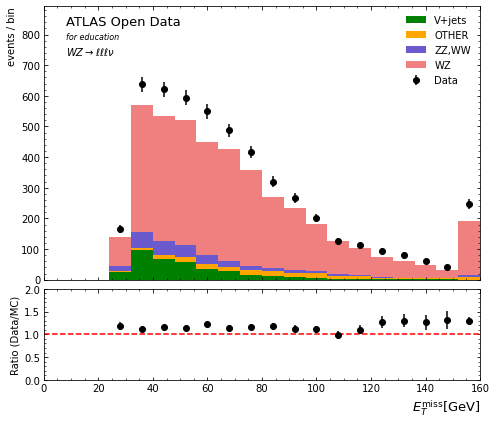

In [24]:
# Flatten the columns before passing them
plot_data(
    np.hstack(main_analysis_df["missing_Et"]),  # Flatten Z_mass column
    0, 160, 8, r"$E_T^{\mathrm{miss}}$" "[GeV]", "events / bin",
    np.hstack(wz_data_df["missing_Et"]), np.hstack(wz_data_df['Weight']),
    np.hstack(diboson_data_df["missing_Et"]), np.hstack(diboson_data_df['Weight']),
    np.hstack(vjets_data_df["missing_Et"]), np.hstack(vjets_data_df['Weight']),
    np.hstack(other_data_df["missing_Et"]), np.hstack(other_data_df['Weight'])
)





/tmp/ipykernel_529/4292167207.py:69: RuntimeWarning: invalid value encountered in divide
  ratio = data_x / mc_x_tot  # Residuals: Data / Total Stacked MC


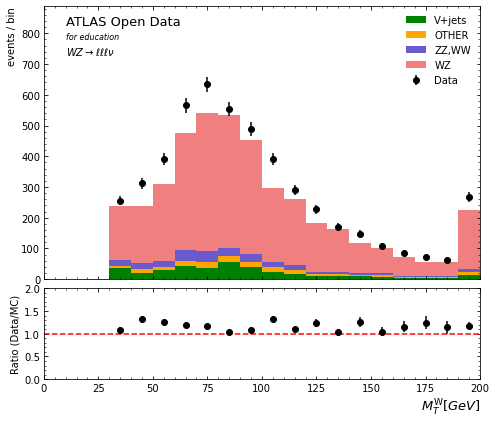

In [25]:
# Flatten the columns before passing them
plot_data(
    main_analysis_df["W_tmass"],  # Flatten Z_mass column
    0, 200, 10, r"$M_T^{\mathrm{W}} [GeV]$", 'events / bin',
    wz_data_df["W_tmass"], wz_data_df['Weight'],
    diboson_data_df["W_tmass"], diboson_data_df['Weight'],
    vjets_data_df["W_tmass"], vjets_data_df['Weight'],
    other_data_df["W_tmass"], other_data_df['Weight']
)

/tmp/ipykernel_529/4292167207.py:69: RuntimeWarning: invalid value encountered in divide
  ratio = data_x / mc_x_tot  # Residuals: Data / Total Stacked MC


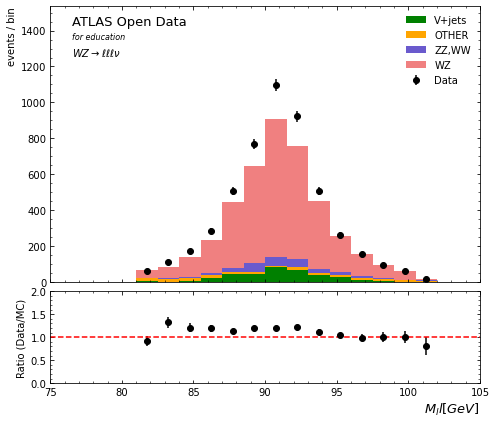

In [26]:
# Flatten the columns before passing them
plot_data(
    np.hstack(main_analysis_df["Z_mass"]),  # Flatten Z_mass column
    75, 105, 1.5, r"$M_ll [GeV]$", 'events / bin',
    np.hstack(wz_data_df["Z_mass"]), np.hstack(wz_data_df['Weight']),
    np.hstack(diboson_data_df["Z_mass"]), np.hstack(diboson_data_df['Weight']),
    np.hstack(vjets_data_df["Z_mass"]), np.hstack(vjets_data_df['Weight']),
    np.hstack(other_data_df["Z_mass"]), np.hstack(other_data_df['Weight'])
)

/tmp/ipykernel_529/4292167207.py:69: RuntimeWarning: invalid value encountered in divide
  ratio = data_x / mc_x_tot  # Residuals: Data / Total Stacked MC


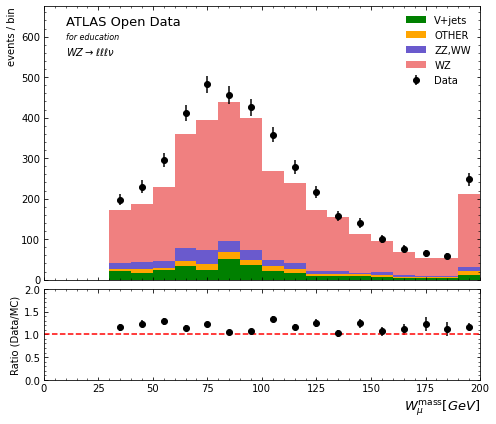

In [27]:
# Flatten the columns before passing them
plot_data(
    np.hstack(main_analysis_df["W_muon"]),  # Flatten Z_mass column
    0, 200, 10, r"$W_μ^{\mathrm{mass}} [GeV]$", 'events / bin',
    np.hstack(wz_data_df["W_muon"]), np.hstack(wz_data_df['Weight']),
    np.hstack(diboson_data_df["W_muon"]), np.hstack(diboson_data_df['Weight']),
    np.hstack(vjets_data_df["W_muon"]), np.hstack(vjets_data_df['Weight']),
    np.hstack(other_data_df["W_muon"]), np.hstack(other_data_df['Weight'])
)

/tmp/ipykernel_529/4292167207.py:69: RuntimeWarning: invalid value encountered in divide
  ratio = data_x / mc_x_tot  # Residuals: Data / Total Stacked MC


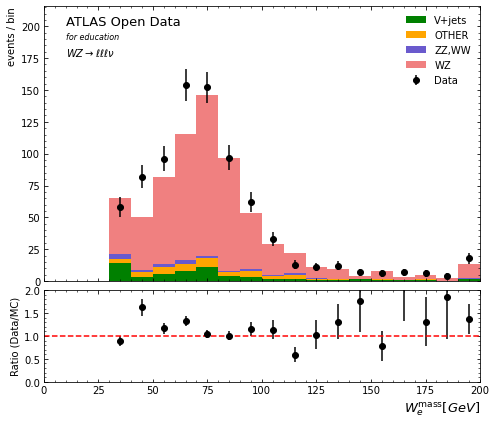

In [28]:
# Flatten the columns before passing them
plot_data(
    np.hstack(main_analysis_df["w_electron"]),  # Flatten Z_mass column
    0, 200, 10, r"$W_e^{\mathrm{mass}} [GeV]$", 'events / bin',
    np.hstack(wz_data_df["w_electron"]), np.hstack(wz_data_df['Weight']),
    np.hstack(diboson_data_df["w_electron"]), np.hstack(diboson_data_df['Weight']),
    np.hstack(vjets_data_df["w_electron"]), np.hstack(vjets_data_df['Weight']),
    np.hstack(other_data_df["w_electron"]), np.hstack(other_data_df['Weight'])
)


/tmp/ipykernel_529/4292167207.py:69: RuntimeWarning: invalid value encountered in divide
  ratio = data_x / mc_x_tot  # Residuals: Data / Total Stacked MC


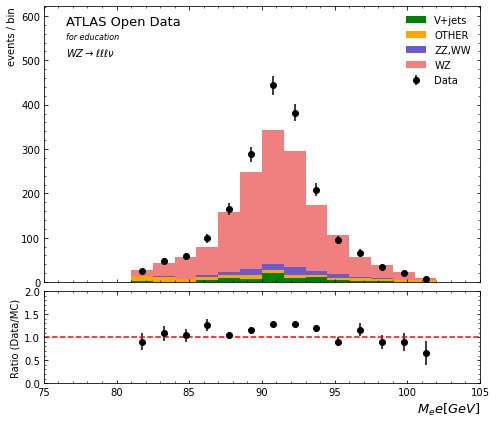

In [29]:
plot_data(
    np.hstack(main_analysis_df["ee_mass"]),  # Flatten Z_mass column
    75, 105, 1.5, r"$M_ee [GeV]$", 'events / bin',
    np.hstack(wz_data_df["ee_mass"]), np.hstack(wz_data_df['Weight']),
    np.hstack(diboson_data_df["ee_mass"]), np.hstack(diboson_data_df['Weight']),
    np.hstack(vjets_data_df["ee_mass"]), np.hstack(vjets_data_df['Weight']),
    np.hstack(other_data_df["ee_mass"]), np.hstack(other_data_df['Weight'])
)

/tmp/ipykernel_529/4292167207.py:69: RuntimeWarning: invalid value encountered in divide
  ratio = data_x / mc_x_tot  # Residuals: Data / Total Stacked MC


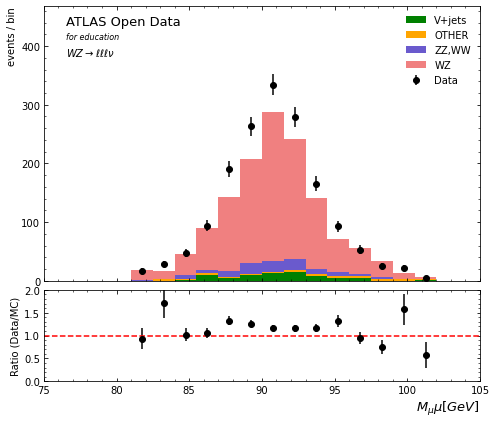

In [30]:
plot_data(
    np.hstack(main_analysis_df["mumu_mass"]),  # Flatten Z_mass column
    75, 105, 1.5, r"$M_μμ [GeV]$", 'events / bin',
    np.hstack(wz_data_df["mumu_mass"]), np.hstack(wz_data_df['Weight']),
    np.hstack(diboson_data_df["mumu_mass"]), np.hstack(diboson_data_df['Weight']),
    np.hstack(vjets_data_df["mumu_mass"]), np.hstack(vjets_data_df['Weight']),
    np.hstack(other_data_df["mumu_mass"]), np.hstack(other_data_df['Weight'])
)

In [31]:
print("Total data events:", len(main_analysis_df['w_electron'].dropna()))

Total data events: 818


In [32]:
print("Total data events:", len(main_analysis_df['W_muon'].dropna()))

Total data events: 4199
